##Lina Conti LI M2


---

# WSD by fine-tuning a transformer-based pre-trained model

**Copy this notebook (File>Save a copy in Drive)**

**Add your name in notebook's name and in notebook's body**

**Deadlines**
- share your copy with me before **January 3rd**
- don't forget to give me **edit rights**
- the execution traces should be visible
- **Strong advice**: 
  - do the TODO1 and TODO2 by next lab session (Dec 16th)
  - freeze the FlauBERT's parameters in your preliminary experiments



We will use the French FrameNet "[ASFALDA](http://asfalda.linguist.univ-paris-diderot.fr/frameIndex.xml)" dataset to experiment the Word Sense Disambiguation task (WSD).

In this dataset, some words have been manually associated with a semantic frame:
- these words are called the **"targets"**
- find the correct frame for a given word token corresponds to a word sense disambiguation task (WSD)**
- note though that a single frame pertains to several lexical units (e.g. FR_Commerce_buy => acheter.v, achat.n, acquérir.v, etc...)
- for this lab session, sentences containing several targets have been duplicated: each line corresponds to a (sentence, target) pair.

FrameNet data also contain annotations for the semantic roles of semantic arguments (Buyer, Seller, Goods ...), which will be ignored for this lab session.

The objective is to build a classifier:
- input = a sentence + target pair
- output = a probability distribution over the various "senses" (namely frames)
  - in basic version, we do not impose that a given target be associated with its possible senses only (namely those that were seen in the training data for this target lemma).

A central trait of our classifier will be to use the contextual representation of the target, as output by a transformer-based pre-trained language model.

Note that *BERT*-like models provide vectors for tokens, each token being potentially a subword.
**In your base version, you will use the FlauBERT vector of the first token of the target word.**

Example: for the target *comprenions* in:

*Nous comprenions bien le cours*

tokenized as :

'\<s>', 'Nous\</w>', 'compren', 'ions\</w>', 'bien\</w>', 'le\</w>', 'cours\</w>', '.\</w>, '\</s>'

you will use the last hidden vector of "compren".

The base classifier will be a neural network comprising
- the pre-trained language model
- which provides the hidden vector of the 1st token of the target word
- plus a simple linear layer + softmax into the set of frames seen in the training set.

We have a single classifier for all lemmas. In basic version, no constraint on which frames can be associated with each target-lemma.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from tqdm import tqdm  
from tqdm.notebook import tqdm # for progress bars in notebooks
from random import shuffle
import os


## Naming conventions

- sentences are already segmented into words (with a rule-based tokenizer)
- but are not segmented into subwords yet
- we use "word" or "w" for the tokens obtained after pre-segmentation
- and "token" for units obtained after *BERT*-like tokenization (BPE ou WordPiece etc...)

- in variable names, we distinguish 
 - integer identifiers for symbols 
   (for the token vocabulary, the frame vocabulary ...)
 - versus the rank of a unit (either word or token) within a sequence
- tid => token identifier
- trk / wrk => token rank / rank of a word in a sequence
- tg => "target", so 
 - tg_wrk = rank of the target word
 - tg_trk = rank of the first token of the target


## Enable use of a GPU

(TODO only at the end, when actually testing / training on full batches)

In [ ]:
# in order to use a GPU
# modify notebook settings:
# Edit > Notebook settings > Hardware accelerator => select "GPU"

# if a GPU is available, we will use it
if torch.cuda.is_available():
    # objet torch.device          
    DEVICE = torch.device("cuda")
        
    print('There are %d GPU(s) available.' % torch.cuda.device_count())    
    device_id = torch.cuda.current_device()
    gpu_properties = torch.cuda.get_device_properties(device_id)
    print("We will use GPU %d (%s) of compute capability %d.%d with "
          "%.2fGb total memory.\n" % 
          (device_id,
          gpu_properties.name,
          gpu_properties.major,
          gpu_properties.minor,
          gpu_properties.total_memory / 1e9))

else:
    print('No GPU available, using the CPU instead.')
    DEVICE = torch.device("cpu")



There are 1 GPU(s) available.
We will use GPU 0 (Tesla T4) of compute capability 7.5 with 15.84Gb total memory.



## "ASFALDA" dataset

A French FrameNet, comprising about 16000 annotated targets, into about 100 distinct frames, along with their semantic role annotations.


### Fetching the data

In [ ]:
if not os.path.exists('./asfalda_data_for_wsd/'):
  # shell commands can be run using !
  !pip install wget
  import wget
  
  # The URL for the dataset zip file.
  url = 'http://www.linguist.univ-paris-diderot.fr/~mcandito/divers/asfalda_data_for_wsd.tgz'

  
  if not os.path.exists('./asfalda_data_for_wsd.tgz'):
    print('Downloading dataset')
    wget.download(url, './asfalda_data_for_wsd.tgz')
    !tar zxf asfalda_data_for_wsd.tgz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=0cd37e265e745295cb55ec1574e762fe035f2a741179c41febc120cbfd831c77
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


### Data loading method

In [ ]:
def load_asfalda_data(gold_data_file, split_info_file):
    """
        Inputs: - asfalda gold data file
                - file indicating the corpus type for each sentence id

        Returns 4 dictionaries (whose keys are corpus types (train/dev/test))
        - sentences = list of sentences, each sent is a list of words
        - list of rank of target word in each sentence
        - list of target lemmas
        - gold labels

        Example:
        sentences['train'] = [['Le', 'code', 'comprend', 'des', 'erreurs','.'],
                              ['Comprends', '-tu', '?']]
         # the targets are the 3rd and first words                     
        tg_wrks['train'] = [2, 0]
        tg_lemmas['train'] = ['comprendre', 'comprendre']
        labels['train'] = ['frame1', 'frame2']
                                
    """
    # load the usual split into train / dev / test
    s = open(split_info_file)
    lines = [ l[:-1].split('\t') for l in s.readlines() ]
    split_info_dic = { line[0]:line[1] for line in lines }

    # dev / train / test sentences
    sentences = {'dev':[], 'train':[], 'test':[]}
    # the word ranks (wrk) for the target words
    tg_wrks = {'dev':[], 'train':[], 'test':[]}
    # target lemmas
    tg_lemmas = {'dev':[], 'train':[], 'test':[]}
    # the labels of targets (= frames)
    labels = {'dev':[], 'train':[], 'test':[]}

    max_sent_len = {'dev':0, 'train':0, 'test':0}
    max_tg_wrk = {'dev':0, 'train':0, 'test':0}

    stream = open(gold_data_file)
    for line in stream.readlines():
        if line.startswith('#'):
            continue
        line = line.strip()
        (sentid, tg_wrk, frame_name, tg_lemma, tg_pos, rest) = line.split('\t',5)
        # role annotation is ignored
        # sentences are pre-segmented into space-separated words
        # => we split, to use the is_split_into_words=True mode of the FlauBERT tokenizer
        sentence = rest.split("\t")[-1].split(' ')
        part = split_info_dic[sentid]
        tg_wrk = int(tg_wrk)

        l = len(sentence)
        sentences[part].append(sentence)
        labels[part].append(frame_name)
        tg_wrks[part].append(tg_wrk)
        tg_lemmas[part].append(tg_lemma)
        if max_sent_len[part] < l: 
            max_sent_len[part] = l 
        if max_tg_wrk[part] < tg_wrk: 
            max_tg_wrk[part] = tg_wrk 
    print("Max sentence length:", max_sent_len)
    print("Max target rank (in words):", max_tg_wrk)
    
    return sentences, tg_wrks, tg_lemmas, labels


### Data loading and defining ids for labels

In [ ]:
gold_data_file = './asfalda_data_for_wsd/sequoiaftb.asfalda_1_3.gold.uniq.nofullant.txt'

# usual split train / dev / test for this corpus
split_info_file = './asfalda_data_for_wsd/sequoiaftb_split_info'

sentences, tg_wrks, tg_lemmas, label_strs = load_asfalda_data(gold_data_file,
                                                              split_info_file)

for p in sentences.keys():
    avgl = sum([len(s) for s in sentences[p]])/len(sentences[p])
    print("%s : %d sentences, average lentgh=%3.2f" 
          %(p, len(sentences[p]), avgl))

# creating label ids for frames seen in training set
i2label = list(set(label_strs['train']))
# id for unknown frame (for dev and test)
i2label.append('*UNK*')

label2i = {x:i for i,x in enumerate(i2label)}
# id of special frame "Other_sense"
i_OTHER_SENSE = label2i['Other_sense']

# sequence of gold labels 
# for each sub-corpus (key = dev/train/test)
labels = {}
for p in label_strs.keys():
    labels[p] = [label2i[x] if x in label2i else label2i['*UNK*'] for x in label_strs[p]]




Max sentence length: {'dev': 115, 'train': 271, 'test': 140}
Max target rank (in words): {'dev': 96, 'train': 267, 'test': 115}
dev : 2688 sentences, average lentgh=38.03
train : 18657 sentences, average lentgh=38.99
test : 3447 sentences, average lentgh=38.45


### TODO1 : MFS Baseline ("most frequent sense")

- Compute the most frequent sense of each **target-lemma**
  (using frequencies in train)

- and compute the MFS baseline, namely the accuracy obtained when choosing the most frequent sense of each target
  - MFS in train
  - MFS in dev (always using frequencies in train to get the most frequent senses)
    - **NB**: in case of unknown target lemma, fall back on the most frequent frame in full training data

- Study the items that are unknown in train:
  - unknown target lemmas
  - unknown frame / target-lemma associations
  - unknown frames
  



In [ ]:
# Compute the most frequent sense of each target-lemma (using frequencies in train)
import pandas as pd

# Sends data to DataFrames
train_df = pd.DataFrame({'lemmas': tg_lemmas['train'], 'labels': label_strs['train']})
dev_df = pd.DataFrame({'lemmas': tg_lemmas['dev'], 'labels': label_strs['dev']})
test_df = pd.DataFrame({'lemmas': tg_lemmas['test'], 'labels': label_strs['test']})

# Counts how many times each lemma is associated with each of its labels
MFS_df = train_df.groupby(["lemmas", "labels"]).size().to_frame(name = 'count').reset_index()
# Selects only the label with the highest count for each lemma
idx = MFS_df.groupby(["lemmas"])['count'].transform(max) == MFS_df['count']

MFS_df = MFS_df[idx]
MFS_df

,lemmas,labels,count
0,aborder,FR_Speak_on_topic,11
2,aboutir,Causation,24
5,aboutissement,Other_sense,4
6,accentuer,FR_Contingency-Objective_influence,7
8,acceptation,FR_Taking_sides,4
...,...,...,...
1477,éviter,Preventing,49
1478,évocation,FR_Speak_on_topic,1
1481,évoquer,FR_Speak_on_topic,45
1482,être_ce_à_dire,Other_sense,2


In [ ]:
from collections import defaultdict

# Finds the most frequent sense in full training data
default_sense = train_df['labels'].value_counts().idxmax()
print(default_sense)

# Fall back on it for unknown lemmas
MFS = defaultdict(lambda: default_sense, zip(MFS_df.lemmas, MFS_df.labels))

Other_sense


In [ ]:
# MFS baseline on train

# Adds a column with the MFS prediction for each example
train_df['MFS'] = train_df['lemmas'].apply(lambda lemma: MFS[lemma])

# Computes accuracy
(train_df.labels == train_df.MFS).sum() / train_df.shape[0]

0.8139572278501367

In [ ]:
# MFS baseline on dev

# Adds a column with the MFS prediction for each example
dev_df['MFS'] = dev_df['lemmas'].apply(lambda lemma: MFS[lemma])

# Computes accuracy
(dev_df.labels == dev_df.MFS).sum() / dev_df.shape[0]

0.7875744047619048

In [ ]:
# MFS baseline on test

# Adds a column with the MFS prediction for each example
test_df['MFS'] = test_df['lemmas'].apply(lambda lemma: MFS[lemma])

# Computes accuracy
(test_df.labels == test_df.MFS).sum() / test_df.shape[0]

0.7919930374238469

In [ ]:
# Study the items that are unknown in train

# number of unknown target lemmas in dev
dev_df[~dev_df.lemmas.isin(train_df.lemmas)].size # to see the lemmas comment out .size

66

In [ ]:
# unknown frames in dev (there are none!)
dev_df[~dev_df.labels.isin(train_df.labels)].size

0

In [ ]:
# number of unknown frame / target-lemma associations

# frame / target-lemma associations in dev
dev_associations = pd.Series( [ str(i) + str(j) for i,j in dev_df[['lemmas', 'labels']].values ] )

# frame / target-lemma associations in train
train_associations = [ str(i) + str(j) for i,j in train_df[['lemmas', 'labels']].values ]

# filters by if the associations in dev are present in train
dev_df[~dev_associations.isin(train_associations)].size # to see the lemmas comment out .size

141

## Data encoding

### FlauBERT tokenization

We use the FlauBERT model, using the Huggingface "transformers" module.

In [ ]:
try:
  import transformers
except ImportError:
  !pip install transformers
  
from transformers import AutoModel, AutoTokenizer, AutoConfig

# flaubert's tokenization uses as first step a tokenization into words by moses
try:
  import sacremoses
except ImportError:
  !pip install sacremoses
  import sacremoses


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 98.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 28.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=465fbf81b4133ce2dbbc2a2e018958c40d31c32a382b9dd5a9c42f2d9c31fead
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses


In [ ]:
# We choose the FlauBERT model

# we load tokenizer and config for now
flaubert_tokenizer = AutoTokenizer.from_pretrained("flaubert/flaubert_base_cased")
flaubert_config = AutoConfig.from_pretrained("flaubert/flaubert_base_cased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.56M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/896k [00:00<?, ?B/s]

### TODO2: Encoding method

The objective is to apply FlauBERT's tokenization, **keeping track of the position of the tokens of the targets**.

Follow the instructions below to fill in the encode method.

In [ ]:

class WSDEncoder:
    def __init__(self, tokenizer, config):
        self.tokenizer = tokenizer
        self.config = config # to get indices of special tokens


    def _tokenize_and_trk(self, sentences, tg_wrks):
      '''
      Input: 
          - sentences: list of sentences split into words
          - tg_wrks: list of the ranks of target words

      Returns:
          - tid_seqs without padding / truncation nor special tokens,
          - first_trk_of_targets: for each sentence, 
                                  the rank in corresponding tid_seq
                                  of the first token of the target word
      '''
      first_trk_of_targets = [-1] * len(sentences)  # list of size len(sentences)
      tid_seqs = [[] for _ in range(len(sentences))] # list of len(sentences) empty lists

      for sent_id, sentence in enumerate(sentences):
        nb_tokens = 0

        for word_id, word in enumerate(sentence):

            # Tokenize the word and add it to the tokenized sentence
            new_tokens = self.tokenizer.encode(word, add_special_tokens=False)
            tid_seqs[sent_id].extend(new_tokens)

            # Look for the token rank of the target
            if first_trk_of_targets[sent_id] == -1: # if we have not found the trk of the target for this sentence yet
              if word_id == tg_wrks[sent_id]: # if we have found it now
                first_trk_of_targets[sent_id] = nb_tokens
              else:
                nb_tokens += len(new_tokens)
      
      return tid_seqs, first_trk_of_targets


    def _truncate(self, tid_seqs, first_trk_of_targets, max_length):
      '''
      Updates tid_seqs and first_trk_of_targets so the sentences are truncated
      so as not to exceed max_length. Ensures that the target token does not get truncated.
      '''
      truncated_tid_seq = []
      truncated_first_trk_of_targets = []

      for seq_id, tid_seq in enumerate(tid_seqs):
        # just truncate evirything to the right after max_length if that doesn't remove the target
        if first_trk_of_targets[seq_id] < max_length:
          truncated_tid_seq.append(tid_seq[:max_length])
          truncated_first_trk_of_targets.append(first_trk_of_targets[seq_id])
        # if the target was going to be truncated, slide the window that will be kept max_length tokens to the right
        # (the target token will become the last token in the truncated sequence)
        else:
          truncated_tid_seq.append(tid_seq[first_trk_of_targets[seq_id]+1-max_length : first_trk_of_targets[seq_id]+1])
          truncated_first_trk_of_targets.append(max_length-1)

      return truncated_tid_seq, truncated_first_trk_of_targets


    def _pad(self, tid_seqs, max_length):
      '''
      Updates tid_seqs so the sentences are padded to all be of length max_length.
      '''
      padded_tid_seq = []

      for tid_seq in tid_seqs:
        padding_size = max_length - len(tid_seq)  # nb of padding tokens to add (can be 0)
        padded_tid_seq.append(tid_seq + padding_size * [self.config.pad_token_id])

      return padded_tid_seq  


    def _add_special_tokens(self, tid_seqs, first_trk_of_targets):
      '''
      Adds the bos and eos special tokens to tid_seqs and updates first_trk_of_targets accordingly.
      '''
      new_tid_seq = []
      new_first_trk_of_targets = []

      for seq_id, tid_seq in enumerate(tid_seqs):
        new_tid_seq.append([self.config.bos_index] + tid_seq + [self.config.eos_index])
        # the trk of targets has changed because we added the bos token before it
        new_first_trk_of_targets.append(first_trk_of_targets[seq_id] + 1)

      return new_tid_seq, new_first_trk_of_targets

    
    def encode(self, sentences, tg_wrks, max_length=100, verbose=False, is_split_into_words=True):
      """ 
      Input: 
        - sentences : list of sentences
           -- if is_split_into_words:
              sentences are already split into words 
              (hence sentences = list of word strings [[w1, w2, w3], [w1, w2]...])
           -- otherwise, sentences are to split on spaces to get words

        - tg_wrks : list of the ranks of target words
          (one rank per sentence, starting at 0 in a sentence)
        - max_length : maximum length in number of tokens

      Returns:
        - tid_seqs : the sentences padded/truncated so that each contains max_length token ids
        - first_trk_of_targets : for each sentence, 
                                 the rank in corresponding tid_seq
                                 of the first token of the target word

      Example with is_split_into_words=True: a batch with one sent
      sentences = [ ['Conséquemment', ',', 'nous', 'comprendrions', '.'] ]
      tg_wrks = [3]

      if the sentence is tokenized into 
        '<s>', 'Con', 'séqu', 'emment</w>', ',</w>', 'nous</w>', 'compr', 'end', 'rions</w>', '.</w>' ....
      the first token rank of the target "comprendrions" is 6 ('compr')

      """
      if not is_split_into_words:
        # Turns list into list of lists
        sentences = [sent.split(' ') for sent in sentences]

      # 1. apply flaubert tokenization *word per word*, and build
      #    tid_seqs first without padding / truncation nor special tokens,
      #    and keep track of token rank of first token of target word
      tid_seqs, first_trk_of_targets = self._tokenize_and_trk(sentences, tg_wrks)

      # 2. then truncate and pad, and add special symbols
      # (write several methods for easier reading)
      tid_seqs, first_trk_of_targets = self._truncate(tid_seqs, first_trk_of_targets, max_length-2)
      tid_seqs, first_trk_of_targets = self._add_special_tokens(tid_seqs, first_trk_of_targets)
      tid_seqs = self._pad(tid_seqs, max_length)
      
      return tid_seqs, first_trk_of_targets

#### Encoding test

In [ ]:
encoder = WSDEncoder(flaubert_tokenizer, flaubert_config)

# test encoder
test_sents = ["Conséquemment , nous comprendrions .",
              "Le code comprend des erreurs .",
            "J' essaie de comprendre les transformers .",  
            "Il n' a pas bien compris le code !"]
# target words are the occurrences of "comprendre"
test_tg_wrks = [3, 2, 3, 5]
max_length=10

# uncomment to test your encode method
tid_seqs, first_trk_of_targets = encoder.encode(test_sents, test_tg_wrks, max_length=10, verbose=True, is_split_into_words=False)

for tid_seq, ft in zip(tid_seqs, first_trk_of_targets):
    print("Len = %d target token rank = %d tid_seq = %s" % (len(tid_seq), ft, str(tid_seq)))
    print(' '.join([flaubert_tokenizer.decode(tid) for tid in tid_seq]), '\n')

Len = 10 target token rank = 6 tid_seq = [0, 1198, 17358, 13299, 14, 65, 18719, 1999, 19614, 1]
<s> Con séqu emment , nous compr end rions </s> 

Len = 10 target token rank = 3 tid_seq = [0, 55, 1138, 976, 23, 3842, 16, 1, 2, 2]
<s> Le code comprend des erreurs . </s> <pad> <pad> 

Len = 10 target token rank = 4 tid_seq = [0, 158, 5213, 15, 965, 22, 14659, 896, 16, 1]
<s> J' essaie de comprendre les transform ers . </s> 

Len = 10 target token rank = 6 tid_seq = [0, 59, 51, 34, 42, 83, 681, 20, 1138, 1]
<s> Il n' a pas bien compris le code </s> 



### TODO3: WSDData class: full encoding and batch production

In [ ]:

class WSDData:
    def __init__(self, corpus_type, sentences, tg_wrks, tg_lemmas, labels, encoder, max_length=100):
        """
        Inputs:
        - corpus type string (train/dev/test)
        - list of sentences (each sentence = list of word strings)
        - list of target word ranks : one per sentence
        - list of gold label id
        - encoder = instance of WSDEncoder

        - max_length = size of encoded sequences, in nb of bert tokens 
                      (padded / truncated via encoder.encode)
    
        Encodes all the data using the relevant identifiers
        """
        
        self.corpus_type = corpus_type # train / dev / test / val
        self.size = len(sentences)
        self.encoder = encoder

        self.labels = labels       # gold label ids
        self.sentences = sentences # list of list of word strings
        self.tg_lemmas = tg_lemmas
        
        tid_seqs, tg_trks = encoder.encode(sentences, tg_wrks, max_length)

        self.tid_seqs = tid_seqs  # sequences of token ids
        self.tg_trks = tg_trks    # target token ranks
        

    def shuffle(self):
      """
      Rearranges all the data in a new random order
      (sentences, tg_lemmas, tg_trks, tid_seqs, labels)

      NB: ** original order is lost **
      """
      # Shuffles the five lists with same order
      temp = list(zip(self.sentences, self.tg_lemmas, self.tg_trks, self.tid_seqs, self.labels))
      shuffle(temp)
      self.sentences, self.tg_lemmas, self.tg_trks, self.tid_seqs, self.labels = zip(*temp)

      # The lists come out as tuples, and so must be converted to lists.
      self.sentences, self.tg_lemmas =  list(self.sentences), list(self.tg_lemmas)
      self.tg_trks, self.tid_seqs, self.labels = list(self.tg_trks), list(self.tid_seqs), list(self.labels)


    # production of a batch
    def make_batches(self, batch_size, device, shuffle_data=False):
        """
        Returns an iterator over 4 torch tensors 
        - batch of token id sequences
        - corresponding batch of target token ranks
        - corresponding batch of labels for these targets
        - corresponding batch of target lemmas
        """
        if shuffle_data:
            self.shuffle()

        #batch generation
        bstart = 0  # index where the batch starts
        N = len(self.sentences)
        while bstart < N:
            bend = min(bstart+batch_size, N)  # index where the batch ends
            # the torch tensors can be directly sent to the right device using .to(device)
            b_tid_seqs = torch.LongTensor(self.tid_seqs[bstart:bend]).to(device)
            b_tg_trks = torch.LongTensor(self.tg_trks[bstart:bend]).to(device)
            b_labels = torch.LongTensor(self.labels[bstart:bend]).to(device)
            b_tg_lemmas = self.tg_lemmas[bstart:bend]

            # use "yield" function to return iterator
            yield (b_tid_seqs, b_tg_trks, b_labels, b_tg_lemmas)
            bstart += batch_size
        

MAX_LENGTH = 100
wsd_data = {}
# key = part of the split corpus (train/test/dev)
for p in sentences.keys():
    print("Encoding part %s ..." % p)
    wsd_data[p] = WSDData(p, sentences[p], tg_wrks[p], tg_lemmas[p], labels[p], 
                          encoder, max_length=MAX_LENGTH)
    # we check that encoding provides the right lengths
    for i, s in enumerate(wsd_data[p].tid_seqs):
        if len(s) != MAX_LENGTH:
            print("Size bug:", i, s)


Encoding part dev ...
Encoding part train ...
Encoding part test ...


## WSDClassifier class: the network for WSD

Base architecture = 
- the FlauBERT model
- plus linear layer + softmax

### TODO4: Digression: matrix operation

Matrix operation to fetch the bert hidden vector of the first
token of the targets.

Input is
1. x = a tensor for a batch of (truncated/padded) sentences
   containing the bert vectors for all tokens of each sentence
 
2. r = a tensor for the token ranks of the first token of the targets
  
=> we want to keep only the bert vectors of these first tokens

TODO: write down the shapes of tensors x and r and of the output tensor


In [ ]:
x = torch.tensor([[[1, 2, 3, 4],
                   [5, 6, 7, 8],
                   [9, 10, 11, 12]],
                  [[13, 14, 15, 16],
                   [17, 18, 19, 20],
                   [21, 22, 23, 24]]])  # shape batch_size x seq_length x emb_size
print(x.shape)
# if token ranks for the two sentences of the batch are (1,2) 
r = torch.tensor([1, 2])  # shape batch_length
# => we want to get the [5, 6, 7, 8] and [21, 22, 23, 24] vectors

# write down the matrix operation
# see this source : https://discuss.pytorch.org/t/how-to-select-specific-vector-in-3d-tensor-beautifully/37724

o = x[torch.arange(x.size(0)), r]
o

torch.Size([2, 3, 4])


tensor([[ 5,  6,  7,  8],
        [21, 22, 23, 24]])

### TODO5: The network : architecture, forward propagation, evaluation

In [ ]:
flaubert_model = AutoModel.from_pretrained("flaubert/flaubert_base_cased", return_dict=True)


Downloading:   0%|          | 0.00/553M [00:00<?, ?B/s]

Some weights of the model checkpoint at flaubert/flaubert_base_cased were not used when initializing FlaubertModel: ['pred_layer.proj.weight', 'pred_layer.proj.bias']
- This IS expected if you are initializing FlaubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class WSDClassifier(nn.Module):

    def __init__(self, num_labels, device, bert_model, bert_config, freeze_bert=True, layers_to_cat=1):
        super(WSDClassifier, self).__init__()

        self.device = device

        # instead of taking flaubert's embeddings only at the last layer
        # we can use the concatenation of embeddings at the layers_to_cat last layers
        self.layers_to_cat = layers_to_cat
                
        # the full *BERT*-like model
        self.bert_layer = bert_model
        # config will allow to get the hidden vectors' size
        self.bert_config = bert_config
        
        # rest of the network (output linear layer and log softmax)
        self.linear_layer = nn.Linear(bert_config.emb_dim * layers_to_cat, num_labels)
        self.log_softmax = nn.LogSoftmax(dim=1)

        # option to either freeze or fine-tune the BERT model
        for param in self.bert_layer.parameters():
          param.requires_grad = not freeze_bert

        # the .to(device) triggers the copy towards the relevant device 
        # (possibly a GPU)
        self.to(device)
        

    def forward(self, b_tid_seq, b_tg_trk):
        """
        Inputs: (all are tensors, on the relevant device)
            - a batch of sentences = a batch of token id sequences 
              (as output in 'input_ids' member of tokenizer output)
            - a batch of target token rank = for each of the sentences, 
              the rank of first token of the target word to disambiguate

        Output: log_softmax scores for the whole batch (batch_size x num_labels)
        """

        #  list of *bert hidden vectors for all the tokens of all the batch sentences at all layers
        all_layers = self.bert_layer(b_tid_seq, output_hidden_states=True).hidden_states
        #  concatenation of the hidden vectors at the layers_to_cat last layers
        #  [ batch_size x seq_len x (bert_emb_size * layers_to_cat) ]
        all_token_representations = torch.cat(all_layers[-self.layers_to_cat:], dim=-1)

        #  - isolate the vector of the (first) token of the target for all the batch sentences
        #    [ batch_size x (bert_emb_size * layers_to_cat) ]
        target_representations = all_token_representations[torch.arange(all_token_representations.size(0)), b_tg_trk]
        #    Tips to do this:
        #    https://discuss.pytorch.org/t/how-to-select-specific-vector-in-3d-tensor-beautifully/37724
        
        #  - and apply linear layer
        #    [ batch_size x num_labels ]
        scores = self.linear_layer(target_representations)
        return self.log_softmax(scores)

            
    def run_on_dataset(self, wsd_data, batch_size=32):
        """
        Run classifier on wsd_data and compute accuracy
        Inputs = 
         - wsd_data (WSDDataset instance)
         - batch_size
        Returns:
         - list of predicted label ids
        """
        pred_labels = []
        
        # toggle evaluation mode of the model (VERY IMPORTANT)
        self.eval()

        with torch.no_grad(): # useless to compute gradients when evaluating
          for b_tid_seqs, b_tg_trks, b_labels, b_tg_lemmas in wsd_data.make_batches(batch_size, self.device):
            Y_hat = self(b_tid_seqs, b_tg_trks) # get all scores
            pred_labels.extend(Y_hat.argmax(dim=-1).tolist()) # choose highest

        return pred_labels


    def evaluate(self, gold_labels, pred_labels):
        """ returns accuracy, nb_correct, nb_total """
        gold_labels = torch.tensor(gold_labels)
        pred_labels = torch.tensor(pred_labels)
        nb_correct = (gold_labels == pred_labels).sum().item()
        nb_total = gold_labels.shape[0]
        accuracy = 100 * nb_correct / nb_total
        return accuracy, nb_correct, nb_total

    def load(self, filename):
        """ loads parameters that were previously trained and saved """
        self.load_state_dict(torch.load(filename))

In [ ]:
# an instance of WSDClassifier
num_labels = len(i2label)
classifier = WSDClassifier(num_labels, DEVICE, flaubert_model, flaubert_config)

# uncomment to see the huge nb of parameters ...
#for name, param in classifier.named_parameters():
#    print("PARAM named %s, of shape %s" % (name, str(param.shape)))
#    print(param)    

#### Test of forward propagation

In [ ]:
# useless to compute gradients when testing
with torch.no_grad():
    # toggle train mode off
    classifier.eval()
    for b_tid_seqs, b_tg_trks, b_labels, b_tg_lemmas in wsd_data['dev'].make_batches(32, classifier.device, shuffle_data=True):
        b_tid_seqs = b_tid_seqs.to(classifier.device)
        b_tg_trks = b_tg_trks.to(classifier.device)
        
        log_probs = classifier(b_tid_seqs, b_tg_trks)
        gold = b_labels[0] #.item()
        print("GOLD LABEL of first ex %d ( = %s)" % (gold, i2label[gold]))
        print("LOG_PROBS before training: %s\n\n" % str(log_probs[0]))
        break


GOLD LABEL of first ex 45 ( = Evidence)
LOG_PROBS before training: tensor([-5.1482, -4.6172, -6.0138, -3.8711, -4.1902, -3.5959, -3.7637, -5.5234,
        -5.8458, -5.2972, -4.5094, -5.6308, -5.5577, -5.1261, -5.5437, -4.2646,
        -6.5333, -4.7462, -3.4424, -5.1902, -5.7456, -4.5710, -5.6263, -4.7519,
        -4.8278, -5.0519, -5.5184, -5.6702, -4.5268, -5.3901, -4.2514, -5.0148,
        -4.9086, -4.3648, -4.7188, -4.9056, -5.5119, -3.4815, -6.0087, -6.2005,
        -4.7202, -4.4581, -5.2738, -4.7468, -4.8462, -5.5344, -4.6955, -4.7539,
        -6.8399, -3.6715, -5.0130, -5.0550, -4.8980, -4.6851, -4.7190, -5.4565,
        -5.0839, -4.2809, -5.2812, -3.5253, -4.4216, -5.4093, -4.4754, -3.8113,
        -5.1358, -4.9758, -4.6529, -3.1754, -6.1799, -4.3250, -4.7841, -5.8441,
        -4.0289, -4.5812, -5.5812, -3.2951, -5.4231, -5.8275, -4.9057, -4.7433,
        -4.8012, -5.9500, -5.6076, -6.1345, -5.2078, -3.5000, -3.9181, -4.4877,
        -4.6161, -6.9715, -5.8900, -4.1914, -5.2633, 

### TODO6: Training : fine-tuning for the WSD task

**NB** full training on train data is **LONG**, so when developping your code, first try on a small part of the data.

**NB** In general when using a *bert model in fine-tuning mode (not frozen), the needed learning rate tends to be lower

In [ ]:
def training_epoch(classifier, train_data, batch_size, optimizer, loss_function):
  """
  Trains classifier for one epoch
  Inputs = 
    - classifier: model to train (WSDClassifier instance)
    - train_data: wsd_data (WSDDataset instance)
    - batch_size (int)
    - optimizer: instance of Optimizer from torh.optim used to update the parameters
    - loss_function: object with a call function that calculates the loss
  Returns:
    - average loss for this epoch (float)
  """

  epoch_losses = []
  classifier.train()
  for b_tid_seqs, b_tg_trks, b_labels, b_tg_lemmas in train_data.make_batches(batch_size, classifier.device, shuffle_data=True):
    
    # Resets the gradient to zero before each forward propagation
    classifier.zero_grad()
    # Forward propagation
    log_probs = classifier(b_tid_seqs, b_tg_trks)
    loss = loss_function(log_probs, b_labels)
    # Back propagation
    loss.backward()
    # Updates parameters
    optimizer.step()

    epoch_losses.append(loss.item())

  return sum(epoch_losses)/len(epoch_losses)


def validation_epoch(classifier, val_data, batch_size, optimizer, loss_function):
  """
  Runs classifier on a validation dataset and computes accuracy and average loss
  Inputs = 
    - classifier: model to use (WSDClassifier instance)
    - val_data: wsd_data (WSDDataset instance)
    - batch_size (int)
    - optimizer: instance of Optimizer from torh.optim used to update the parameters
    - loss_function: object with a call function that calculates the loss
  Returns:
    - average loss on this dataset (float)
    - accuracy on this dataset
  """

  epoch_losses = []
  classifier.eval()
  with torch.no_grad():

    pred_labels = []
    for b_tid_seqs, b_tg_trks, b_labels, b_tg_lemmas in val_data.make_batches(BATCH_SIZE, DEVICE):
      
      log_probs = classifier(b_tid_seqs, b_tg_trks)

      # compute loss
      loss = loss_function(log_probs, b_labels)
      epoch_losses.append(loss.item())

      # to compute accuracy later
      pred_labels.extend(log_probs.argmax(dim=-1).tolist())

  epoch_loss = sum(epoch_losses)/len(epoch_losses)
  accuracy, _, _ = classifier.evaluate(val_data.labels, pred_labels)
  return epoch_loss, accuracy


def train(classifier, train_data, val_data, lr, batch_size, epochs, patience, out_model_file):
  """
  Trains and validates a classifier for a given number of epochs or until early stopping
  Inputs = 
    - classifier: model to train (WSDClassifier instance)
    - train_data: wsd_data (WSDDataset instance)
    - val_data: wsd_data (WSDDataset instance)
    - lr: learning rate (float)
    - batch_size (int)
    - epochs: maximum number of epochs to train for (int)
    - patience: how long to wait before early stopping after the last time validation loss improved (int)
    - out_model_file: path where to save the trained model
  Returns:
    - list of train losses for each epoch
    - list of validation losses for each epoch
  """

  loss_function = nn.NLLLoss(reduction='mean')
  # SGD is quicker (more convenient for debug phase)
  #optimizer = optim.SGD(classifier.parameters(), lr=lr)
  optimizer = optim.Adam(classifier.parameters(), lr=lr)

  # losses at each epoch (on train / on validation set)
  train_losses = []
  val_losses = []
  val_accuracies = []
  min_val_loss = None # used to find the best iteration

  for e in range(epochs):
    print(f"EPOCH {e}")
    
    # train
    train_loss = training_epoch(classifier, train_data, batch_size, optimizer, loss_function)
    train_losses.append(train_loss)

    # validate
    val_loss, accuracy = validation_epoch(classifier, val_data, batch_size, optimizer, loss_function)    
    val_losses.append(val_loss)    
    val_accuracies.append(accuracy)

    print(f"train loss: {train_loss}, validation loss: {val_loss}, validation accuracy: {accuracy}\n")

    # early stopping
    if min_val_loss == None or val_loss < min_val_loss:
      min_val_loss = val_loss  
      counter = 0
      # save the model  (it's the best one so far)
      torch.save(classifier.state_dict(), out_model_file)
    else:
      counter += 1
      if counter >= patience:
          print(f"EARLY STOP - best epoch was epoch {e-counter}")
          break
  
  return train_losses, val_losses

In [ ]:
# training

# an instance of WSDClassifier
num_labels = len(i2label)
classifier = WSDClassifier(num_labels, DEVICE, flaubert_model, flaubert_config, freeze_bert=False)#, layers_to_cat=4)

# hyperparameters
BATCH_SIZE = 128
LR = 0.00005
NB_EPOCHS = 20
PATIENCE = 5

config_name = 'sequoiaftb.asfalda_1_3.wsd.lr' + 'Adam' + str(LR) + '_bs' + str(BATCH_SIZE)
out_model_file = './' + config_name + '.model'
out_log_file = './' + config_name + '.log'

# to speed up during debug: train on dev
test_data = wsd_data['test']
train_data = wsd_data['train']
val_data = wsd_data['dev']

# training
# - basic : train for NB_EPOCHS
# - BONUS : early stopping: stop epoch loop as soon as accuracy on dev decreases
train_losses, val_losses = train(classifier, train_data, val_data, LR, BATCH_SIZE, NB_EPOCHS, PATIENCE, out_model_file)

print("train losses: %s" % ' / '.join([ "%.4f" % x for x in train_losses]))
print("val   losses: %s" % ' / '.join([ "%.4f" % x for x in val_losses]))

EPOCH 0
train loss: 1.4555628785531816, validation loss: 0.4583070561999366, validation accuracy: 85.86309523809524

EPOCH 1
train loss: 0.407011967815765, validation loss: 0.3549931957608178, validation accuracy: 88.69047619047619

EPOCH 2
train loss: 0.24337722958154875, validation loss: 0.3238854848203205, validation accuracy: 89.73214285714286

EPOCH 3
train loss: 0.14291889391431253, validation loss: 0.3328513708852586, validation accuracy: 90.06696428571429

EPOCH 4
train loss: 0.12325168847527405, validation loss: 0.3644834253050032, validation accuracy: 90.10416666666667

EPOCH 5
train loss: 0.08175288395292751, validation loss: 0.39830060374169124, validation accuracy: 90.47619047619048

EPOCH 6
train loss: 0.05434332166683592, validation loss: 0.377723766934304, validation accuracy: 90.69940476190476

EPOCH 7
train loss: 0.03794409042823907, validation loss: 0.3876177817583084, validation accuracy: 90.8110119047619

EARLY STOP - best epoch was epoch 2
train losses: 1.4556 / 0

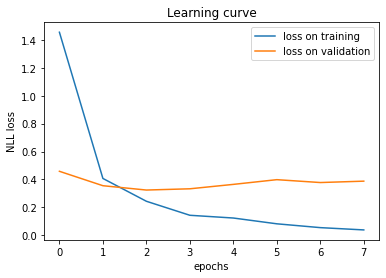

In [ ]:
# Graphs to visualize the training process

from matplotlib import pyplot as plt 

plt.plot(train_losses, label = 'loss on training')
plt.plot(val_losses, label = 'loss on validation')
plt.title('Learning curve')
plt.xlabel('epochs')
plt.ylabel('NLL loss')
plt.legend()
plt.show()

### TODO7: Evaluation

In [ ]:
classifier.load(out_model_file)

In [ ]:
# run on dev and evaluate (I'm running on test)

pred_labels = classifier.run_on_dataset(test_data, batch_size=BATCH_SIZE)
accuracy, nb_correct, nb_total = classifier.evaluate(test_data.labels, pred_labels)

print(f'Accuracy: {accuracy}\nNumber of correct examples: {nb_correct}\nTotal number of examples: {nb_total}')

Accuracy: 90.94865100087033
Number of correct examples: 3135
Total number of examples: 3447


### Generalization analysis

In [ ]:
# toggle evaluation mode of the model
classifier.eval()

gold_unseen = 0 # number of gold lemma-frame associations unseen in train
pred_unseen = 0 # number of predicted lemma-frame associations unseen in train
wrong_pred_unseen = 0 # number of predicted unseen in train lemma-frame associations that are wrong
correct_pred_unseen = 0 # number of predicted unseen in train lemma-frame associations that are correct
wrong = 0 # number of wrong predictions

with torch.no_grad(): 
  for b_tid_seqs, b_tg_trks, b_labels, b_tg_lemmas in test_data.make_batches(BATCH_SIZE, DEVICE):
    
    Y_hat = classifier(b_tid_seqs, b_tg_trks) 
    pred_labels = Y_hat.argmax(dim=-1) 

    for b in range(len(b_labels)):
      # if the gold lemma-frame association for this example is not in the train associations
      gold_unseen_association = (b_tg_lemmas[b] + i2label[b_labels[b]]) not in train_associations
      # if the predicted lemma-frame association for this example is not in the train associations
      pred_unseen_association = (b_tg_lemmas[b] + i2label[pred_labels[b]]) not in train_associations
      # if the prediction is wrong
      wrong_prediction = b_labels[b] != pred_labels[b]

      gold_unseen += gold_unseen_association
      pred_unseen += pred_unseen_association
      wrong_pred_unseen += (wrong_prediction and pred_unseen_association)
      correct_pred_unseen += (not wrong_prediction and pred_unseen_association)
      wrong += wrong_prediction

In [ ]:
print(f"Number of gold lemma-frame associations unseen in training: {gold_unseen}")
print(f"Number of predicted lemma-frame associations unseen in training: {pred_unseen}\n")

print(f"Number of predicted lemma-frame associations unseen in training that were wrong: {wrong_pred_unseen}")
print(f"Number of predicted lemma-frame associations unseen in training that were correct: {correct_pred_unseen}\n")

print(f"Percentage of unseen in training lemma-frame associations predicted that were correct: {(correct_pred_unseen/pred_unseen) * 100}")
print(f"Percentage of unseen in training lemma-frame associations predicted that were wrong: {(wrong_pred_unseen/pred_unseen) * 100}\n")

print(f"Number of wrong predictions {wrong}")
print(f"Percentage of wrong predictions that were lemma-frame associations unseen in training: {(wrong_pred_unseen/wrong) * 100}\n")

print(f"Percentage of gold target-lemma associations that are unseen in training: {(gold_unseen/len(test_data.tg_lemmas)) * 100}\n")

print(f"Percentage of predicted target-lemma associations that are wrong and unseen in training: {(wrong_pred_unseen/len(test_data.tg_lemmas)) * 100}")
print(f"Percentage of predicted target-lemma associations that are correct and unseen in training: {100*correct_pred_unseen/len(test_data.tg_lemmas)}")

Number of gold lemma-frame associations unseen in training: 61
Number of predicted lemma-frame associations unseen in training: 80

Number of predicted lemma-frame associations unseen in training that were wrong: 54
Number of predicted lemma-frame associations unseen in training that were correct: 26

Percentage of unseen in training lemma-frame associations predicted that were correct: 32.5
Percentage of unseen in training lemma-frame associations predicted that were wrong: 67.5

Number of wrong predictions 359
Percentage of wrong predictions that were lemma-frame associations unseen in training: 15.041783332824707

Percentage of gold target-lemma associations that are unseen in training: 1.769654772265738

Percentage of predicted target-lemma associations that are wrong and unseen in training: 1.5665795803070068
Percentage of predicted target-lemma associations that are correct and unseen in training: 0.7542790832608065


## Scale ("barème")

- basic system will give 12 points

- quality of code / comments = 2 points


- various additional points (to choose)

  - generalization analysis
   Do you think it would be better to predict seen-in-train lemma/frame associations only ?
   (in order to answer that question, propose and implement simple analysis of the predictions performed without any control of the frame/lemma association)

  - implement an option to only predict seen-in-train lemma/frame associations

  - nice hyperparameter search

  - high results thanks to nice hyperparameter search

  - implement early stopping

  - does it help to fine-tune with a MLP instead of single layer ?

  - does it help to use a concatenation of flaubert's embeddings at different layers instead of the last layer only (eg 4 last layers, cf. table 7 of devlin et al. 2019) (do this in frozen mode only)

  - does it help to add a lemma embedding of the target (concatenate it to the bert output, before final linear layer)?

  - ... other ideas are welcome ...

Approximate expected accuracy:
 - In frozen mode, basic system can reach 83 / 84 % on the dev set when well trained

 - In fine-tuning mode: results seem unstable
  - take care to search for an appropriate learning rate
  - some of the runs get stuck at 37% of accuracy, corresponding to assigning the MFS to all the instances ("other_sense" frame)
  - when learning goes well, accuracy can reach 88, or even 90% for some runs


NB: write below what you chose to investigate / implement.
Summarize your results / hyper-parameter search.

Your notebook should show traces of a complete training and evaluation phase.

## Additional points implemented

- ### Early stopping

  Early stopping is implemented in the `train` function. When validation loss hasn't improved for `patience` epochs, training is interrupted. The model which is saved is the one that achieved the best validation loss, not the one at the end of the training procedure.

  When training the model, I noticed that sometimes loss started to become worse while accuracy on the dev set was still improving a little. Using the parameters that obtained the best validation loss, I had a better accuracy on the test set than using those that obtained the best validation accuracy. So, I used loss as a stopping criterion for early stopping instead of using accuracy as was suggested. 

- ### Concatenation of flaubert's embeddings at different layers
  
  As suggested by the results in table 7 of devlin et al. 2019, I implemented an option to use as contextual representations not only the embeddings produced at the last flaubert layer, but a concatenation of those produced by different layers. The model now uses a concatenation of the embeddings at the last `layers_to_cat` layers instead of only the last one.

  With flaubert's parameter's frozen, by using the concatenation of the 4 last layer embeddings, as suggested in the paper, the test accuracy increased from 86.02% to 87.32%.

  I tried to use the concatenation with fine-tuning (parameters not frozen), but this did not lead to a better performance. Accuracy stayed roughly the same and even decreased sometimes.

- ### Best hyperparameters

  The best set of hyperparameters I have found (through trial and error, no 'nice' hyperparameter search, sorry...) in fine-tuning mode is a learning rate of 0.00005, a batch size of 128 and no concatenation of layer embeddings. This model achieved an accuracy of 90.95% on the test set.

  In feature extraction mode (with flaubert parameters frozen), the best combination was a learning rate of 0.0005, a batch size of 256 and the concatenation of the embeddings at the four last layers. This model achieved an accuracy of 87.32% on the test set. 

- ### Generalization analysis

  In the last code block, I ran some tests to assess whether it could be better to predict seen-in-train lemma/frame associations only. I measured that 15% of the wrong predictions the model made were unseen target-lemma associations. These make up 1.57% of all predictions. So, it looks like we could gain +1.57 accuracy by blocking unseen in training associations from being predicted.
  
  However, there are also unseen associations in the gold data. 26 of those were correctly predicted by the current model (or 0.75% of test examples). So, in reality, the proposed modification could only produce a gain in accuracy of up to 1.57 - 0.75 = +0.82. Given that we are not even sure the model's second-best prediction that we would use instead would be the correct one, the improvement would probably be less than that.
  
  The modification would also make it plain impossible for the model to correctly predict all unseen associations in the gold data (1.77% of the test data), even if we managed to improve the model in other ways. So, I am not fully convinced by the idea of blocking unseen in training target-lemma associations. But the only way to know for sure would be to try it, which I didn't have time to do, maybe the small gain would make it worthwhile after all.

  @@ C'est un excellent TP, bravo. Analyse très pertinente.